Saving P12.png to P12 (1).png
[OK] 30 points → lines.hex / points.csv 생성 (sx=1.241, sy=0.980, y_shrink=0.98)
첫 8줄 미리보기:
11B052081F
1040F9E621
0F3109BA44
0DD2212C83
0964195C9A
0AE4D1B297
0D94BA0CEC
1067617FC3


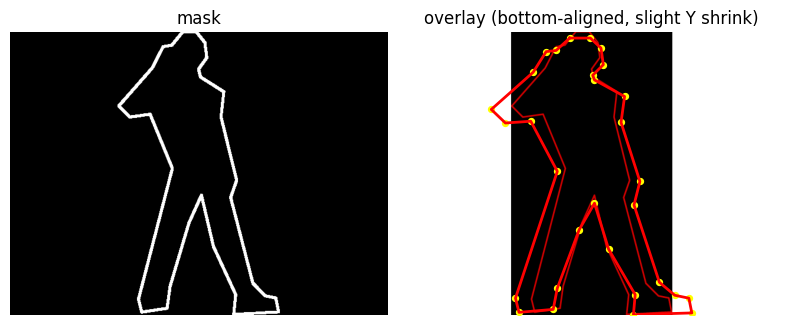

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# =========================================================
# Pattern → VGA 좌표(640x480)
#  - 빨간 외곽선 추출(HSV)
#  - 꼭짓점 30개 근사
#  - X만 [150,490] 밴드에 맞춤 (sx를 자동계산)
#  - Y는 "살짝 줄임(sy=y_shrink)" + "하단 정렬"
#  - 38비트( x1[9:0] y1[8:0] x2[9:0] y2[8:0] ) 헥사로 패킹
#  - 미리보기 & 다운로드
# =========================================================
# !pip -q install opencv-python-headless numpy matplotlib

import numpy as np, cv2, os
import matplotlib.pyplot as plt
from google.colab import files

# ---------------------------
# 패킹: { x1[9:0], y1[8:0], x2[9:0], y2[8:0] }
# ---------------------------
X_MAX_BITS, Y_MAX_BITS = 1023, 511  # 패킹 비트폭 한계(화면은 640x480이므로 OK)
def pack38(x1, y1, x2, y2):
    if not (0 <= x1 <= X_MAX_BITS and 0 <= x2 <= X_MAX_BITS and 0 <= y1 <= Y_MAX_BITS and 0 <= y2 <= Y_MAX_BITS):
        raise ValueError(f"out of range: ({x1},{y1})->({x2},{y2})")
    w  = (x1 & 0x3FF) << 28
    w |= (y1 & 0x1FF) << 19
    w |= (x2 & 0x3FF) <<  9
    w |= (y2 & 0x1FF)
    return w

# ---------------------------
# 시계방향 정렬
# ---------------------------
def ensure_clockwise(pts):
    pts = np.asarray(pts)
    x, y = pts[:,0], pts[:,1]
    area2 = np.sum(x*np.roll(y,-1) - np.roll(x,-1)*y)
    if area2 > 0:  # CCW면 뒤집어 CW로
        pts = pts[::-1].copy()
    return pts

# ---------------------------
# (옵션) VGA 레터박스
# ---------------------------
def to_vga_letterbox(img_bgr, W=640, H=480):
    h, w = img_bgr.shape[:2]
    scale = min(W/w, H/h)
    newW, newH = int(w*scale), int(h*scale)
    resized = cv2.resize(img_bgr, (newW, newH), interpolation=cv2.INTER_AREA)
    canvas = np.full((H, W, 3), 255, dtype=np.uint8)
    ox, oy = (W-newW)//2, H-newH
    canvas[oy:oy+newH, ox:ox+newW] = resized
    return canvas, ox, oy, scale

# ---------------------------
# 빨간 외곽선 추출 (HSV 두 구간)
# ---------------------------
def extract_red_contour(vga_bgr,
                        erode_iter=0, dilate_iter=1,
                        hmin=0, hmax=10, hmin2=170, hmax2=180,
                        smin=80, vmin=80):
    hsv = cv2.cvtColor(vga_bgr, cv2.COLOR_BGR2HSV)
    m1 = cv2.inRange(hsv, (hmin,  smin, vmin), (hmax, 255, 255))
    m2 = cv2.inRange(hsv, (hmin2, smin, vmin), (hmax2,255, 255))
    mask = cv2.bitwise_or(m1, m2)
    if erode_iter:  mask = cv2.erode(mask, None, iterations=erode_iter)
    if dilate_iter: mask = cv2.dilate(mask, None, iterations=dilate_iter)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        raise RuntimeError("빨간 외곽선을 찾지 못했습니다. HSV/erode/dilate 파라미터를 조정하세요.")
    cnt = max(cnts, key=cv2.contourArea)
    return cnt, mask

# ---------------------------
# 꼭짓점 N개로 근사
# ---------------------------
def approx_to_N_points(contour, target_N=30):
    peri = cv2.arcLength(contour, True)
    lo, hi = 0.0, 0.15*peri
    best = None
    for _ in range(30):
        eps = (lo+hi)/2
        approx = cv2.approxPolyDP(contour, eps, True)
        n = len(approx)
        if n == target_N:
            best = approx; break
        if n > target_N: lo = eps
        else: hi = eps
        if best is None or abs(n-target_N) < abs(len(best)-target_N):
            best = approx
    pts = best.reshape(-1,2)

    if len(pts) != target_N:  # 균등 길이 리샘플
        C = contour.reshape(-1,2)
        seg = np.sqrt(np.sum(np.diff(C, axis=0, append=C[:1])**2, axis=1))
        s = np.cumsum(seg); s = np.insert(s, 0, 0)
        L = s[-1]
        t = np.linspace(0, L, target_N, endpoint=False)
        out = []
        for ti in t:
            idx = np.searchsorted(s, ti, side="right")-1
            p0 = C[idx]; p1 = C[(idx+1)%len(C)]
            l0, l1 = s[idx], s[idx+1]
            a = 0 if l1==l0 else (ti-l0)/(l1-l0)
            out.append((1-a)*p0 + a*p1)
        pts = np.array(out, dtype=np.float32)
    return pts.astype(np.int32)

# ---------------------------
# 핵심: X만 [150,490]에 맞추고,
#      Y는 sy=y_shrink(예: 0.98)로 아주 살짝만 줄인 뒤 "하단 정렬"
# ---------------------------
def transform_fit_xband_bottom_shrinkY(pts,
                                       target_w=640, target_h=480,
                                       x_min=150, x_max=490,
                                       y_shrink=0.98):  # 0.95~0.99 범위 추천
    P = np.asarray(pts, dtype=np.float32)

    # 원본 bbox/중심
    x0, y0 = P[:,0].min(), P[:,1].min()
    x1, y1 = P[:,0].max(), P[:,1].max()
    w0 = max(1.0, x1 - x0)
    h0 = max(1.0, y1 - y0)
    cx0 = (x0 + x1) * 0.5
    cy0 = (y0 + y1) * 0.5

    # X 스케일: 밴드 폭에 맞춤
    avail_w = x_max - x_min
    sx = avail_w / w0

    # Y 스케일: 살짝만 줄임
    sy = float(y_shrink)

    # 스케일 후 높이
    h1 = h0 * sy

    # 목표 중심: X는 밴드 중앙, Y는 바닥 정렬
    cx_t = (x_min + x_max) * 0.5         # 320
    cy_t = (target_h - 1) - (h1 * 0.5)   # 바닥에 붙도록 중심 이동

    # 변환
    P2 = P.copy()
    P2[:,0] = (P2[:,0] - cx0) * sx + cx_t
    P2[:,1] = (P2[:,1] - cy0) * sy + cy_t

    # 정수화 + VGA 범위 클램프
    P2 = np.rint(P2).astype(np.int32)
    P2[:,0] = np.clip(P2[:,0], 0, target_w - 1)
    P2[:,1] = np.clip(P2[:,1], 0, target_h - 1)
    return P2, (sx, sy), h1

# ---------------------------
# 최종: 변환 + 헥사 패킹
# ---------------------------
def transform_and_pack_hex_lines_bottom_shrinkY(pts,
                                                x_min=150, x_max=490,
                                                y_shrink=0.98):
    pts = ensure_clockwise(pts)
    pts2, (sx, sy), h1 = transform_fit_xband_bottom_shrinkY(
        pts,
        target_w=640, target_h=480,
        x_min=x_min, x_max=x_max,
        y_shrink=y_shrink
    )
    hex_lines = []
    n = len(pts2)
    for i in range(n):
        x1, y1 = map(int, pts2[i])
        x2, y2 = map(int, pts2[(i+1) % n])
        # VGA 범위(0..639, 0..479) 보정 후 패킹
        x1 = max(0, min(639, x1)); x2 = max(0, min(639, x2))
        y1 = max(0, min(479, y1)); y2 = max(0, min(479, y2))
        hex_lines.append(f"{pack38(x1,y1,x2,y2):010X}")
    return hex_lines, (sx, sy), pts2

# =========================================================
# 실행부 (Colab)
# =========================================================

# 0) 업로드
up = files.upload()
img_path = list(up.keys())[0]

# 1) VGA 레터박스 리사이즈
src = cv2.imread(img_path, cv2.IMREAD_COLOR)
vga, offx, offy, scl = to_vga_letterbox(src, 640, 480)

# 2) 빨간 외곽선 → 30점
TARGET_N = 30
ERODE, DILATE = 0, 1
HMIN, HMAX   = 0, 10
HMIN2,HMAX2  = 170, 180
SMIN, VMIN   = 80, 80
cnt, mask = extract_red_contour(vga, ERODE, DILATE, HMIN, HMAX, HMIN2, HMAX2, SMIN, VMIN)
pts = approx_to_N_points(cnt, TARGET_N)

# 3) 변환 + 패킹 (X=[150,490], Y는 y_shrink만큼 줄이고 바닥 정렬)
X_BAND_MIN, X_BAND_MAX = 150, 490
Y_SHRINK = 0.98   # ← 여기만 살짝 조절(예: 0.99, 0.97)
hex_lines, (sx, sy), pts2 = transform_and_pack_hex_lines_bottom_shrinkY(
    pts,
    x_min=X_BAND_MIN, x_max=X_BAND_MAX,
    y_shrink=Y_SHRINK
)

# 4) 저장
open("lines.hex","w").write("\n".join(hex_lines))
open("points.csv","w").write("\n".join([f"{x},{y}" for x,y in pts2]))

print(f"[OK] {len(pts2)} points → lines.hex / points.csv 생성 (sx={sx:.3f}, sy={sy:.3f}, y_shrink={Y_SHRINK})")
print("첫 8줄 미리보기:")
print("\n".join(hex_lines[:8]))

# 5) 미리보기
plt.figure(figsize=(8,5))
plt.subplot(1,2,1); plt.title("mask"); plt.axis("off"); plt.imshow(mask, cmap="gray")
plt.subplot(1,2,2); plt.title("overlay (bottom-aligned, slight Y shrink)"); plt.axis("off")
plt.imshow(cv2.cvtColor(vga, cv2.COLOR_BGR2RGB))
pp = np.vstack([pts2, pts2[0]])
plt.plot(pp[:,0], pp[:,1], '-r', lw=2)
plt.scatter(pts2[:,0], pts2[:,1], s=18, c='yellow')
plt.tight_layout(); plt.show()

# 6) 다운로드 (Colab/비Colab 모두 커버)
def _in_colab():
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

if _in_colab():
    try:
        files.download("lines.hex")
        files.download("points.csv")
    except Exception as e:
        print("download hint:", e)
else:
    # Jupyter/로컬이라면 링크로 제공
    try:
        from IPython.display import FileLink, display
        display(FileLink("lines.hex", result_html_prefix="Download HEX: "))
        display(FileLink("points.csv", result_html_prefix="Download CSV: "))
    except Exception as e:
        print("링크 생성 실패:", e)
